In [1378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile

In [1379]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

In [1380]:
# Cài đặt các hàm cần thiết ở đây
class OLSLinearRegression:
    def fit(self, X, y):
        #X_pinv is the pseudoinverse of X, which is defined as X_pinv = (X.T * X)^(-1) * X.T
        X_pinv = np.linalg.inv(X.T @ X) @ X.T    # np.linalg.pinv(X)
        self.w = X_pinv @ y

        return self

    
    def get_params(self):
        return self.w.round(3)


    def predict(self, X):
        # X is a matrix of shape (n_samples, n_features)
        # w is a vector of shape (n_features, )
        # the result is: y = X * w, a vector of shape (n_samples, )
        #.ravel() is used to convert a matrix into a vector
        # vector multiplication with matrix is the same as matrix multiplication with matrix
        return np.sum(self.w.ravel() * X, axis=1)   

In [1381]:
def mae(y, y_hat):
    return np.mean(np.abs(y.ravel() - y_hat.ravel()))

In [1382]:
def plot_regression(lr, x, y):  
    # Plot data
    plt.scatter(x, y, color='b', marker='o')
  

    # Plot regression line
    y_pred = lr.predict(x.reshape(-1, 1))
    plt.plot(x, y_pred, color='r')
  
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.grid()
    plt.show()

In [1383]:
def plot_data(x, y):
    plt.scatter(x, y, color='b', marker='o')
  
    plt.xlabel('x')
    plt.ylabel('y')
  
    plt.grid()
    plt.show()

In [1384]:
def getTrain(index, folks):
    Train = np.empty((0, folks[0].shape[1]))
    for i in range(len(folks)):
        if i != index:
            Train = np.concatenate((Train, folks[i]))
    return Train

In [1385]:
def cross_validation_model(Df_np, k_cluster):
    folks = np.array_split(Df_np, k_cluster) # split data to 10 folds
    mae_arr = np.zeros(k_cluster) # array to store mae of each fold
    for i in range(k_cluster):
        data_train = getTrain(i, folks) # get train data (9 folds except i-th fold)
        data_test = folks[i]            # get test data (i-th fold)

        X_test, y_test = data_test[:, :-1], data_test[:, -1]  #all features and salary in test data

        X_train, y_train = data_train[:, :-1], data_train[:, -1] #all features in each folds and salary in train data

        lr = OLSLinearRegression().fit(X_train, y_train) # fit model
        y_pre = lr.predict(X_test) # predict salary
        mae_arr[i] = mae(y_test, y_pre) # calculate mae of each fold
    return np.mean(mae_arr) # calculate mean of mae of 10 folds

### model1 (variance)

In [1386]:
# Assuming 'data' is your dataset in the form of a pandas DataFrame
variances = train.var()

for variance, col in zip(variances, train.columns):
    print(f"{col}: Variance = {variance:.6f}")


Gender: Variance = 0.182823
10percentage: Variance = 100.977028
12percentage: Variance = 123.206725
CollegeTier: Variance = 0.070690
Degree: Variance = 0.072944
collegeGPA: Variance = 65.779591
CollegeCityTier: Variance = 0.207856
English: Variance = 10826.047480
Logical: Variance = 7776.377601
Quant: Variance = 15286.541814
Domain: Variance = 0.219270
ComputerProgramming: Variance = 41203.288452
ElectronicsAndSemicon: Variance = 24773.345677
ComputerScience: Variance = 31447.162531
MechanicalEngg: Variance = 9175.991096
ElectricalEngg: Variance = 7193.708071
TelecomEngg: Variance = 10830.109371
CivilEngg: Variance = 1091.923718
conscientiousness: Variance = 1.053258
agreeableness: Variance = 0.926198
extraversion: Variance = 0.941865
nueroticism: Variance = 1.035130
openess_to_experience: Variance = 1.061213
Salary: Variance = 49316623059.096588


In [1387]:
var_thres = VarianceThreshold(threshold=0.1)
var_thres.fit(X_train)

VarianceThreshold(threshold=0.1)

In [1388]:
constant_columns = [column for column in X_train.columns if column not in X_train.columns[var_thres.get_support()]]

X_train = train.drop(constant_columns, axis=1)
X_test = test.drop(constant_columns, axis=1)

model1 = X_train.columns

Df_np = X_train.to_numpy()
np.random.default_rng().shuffle(Df_np, axis=0)
result1 = cross_validation_model(Df_np, 10)

print(len(model1))


22


In [1389]:
print('mae avg of model1: ',result1)

mae avg of model1:  111939.01181435336


In [1390]:
X_train = X_train.drop(['Salary'], axis=1).to_numpy()
y_train = train.loc[:, 'Salary'].to_numpy()

X_test = X_test.drop(['Salary'], axis=1).to_numpy()
y_test = test.loc[:, 'Salary'].to_numpy()

lr = OLSLinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('model1: ', len(model1))
print('mae of model1: ', mae(y_test, y_pred))


model1:  22
mae of model1:  103766.94961323985


### model2 (correlation coefficient)

In [1391]:
def correlation(dataset, threshold):
    col_corr = list()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

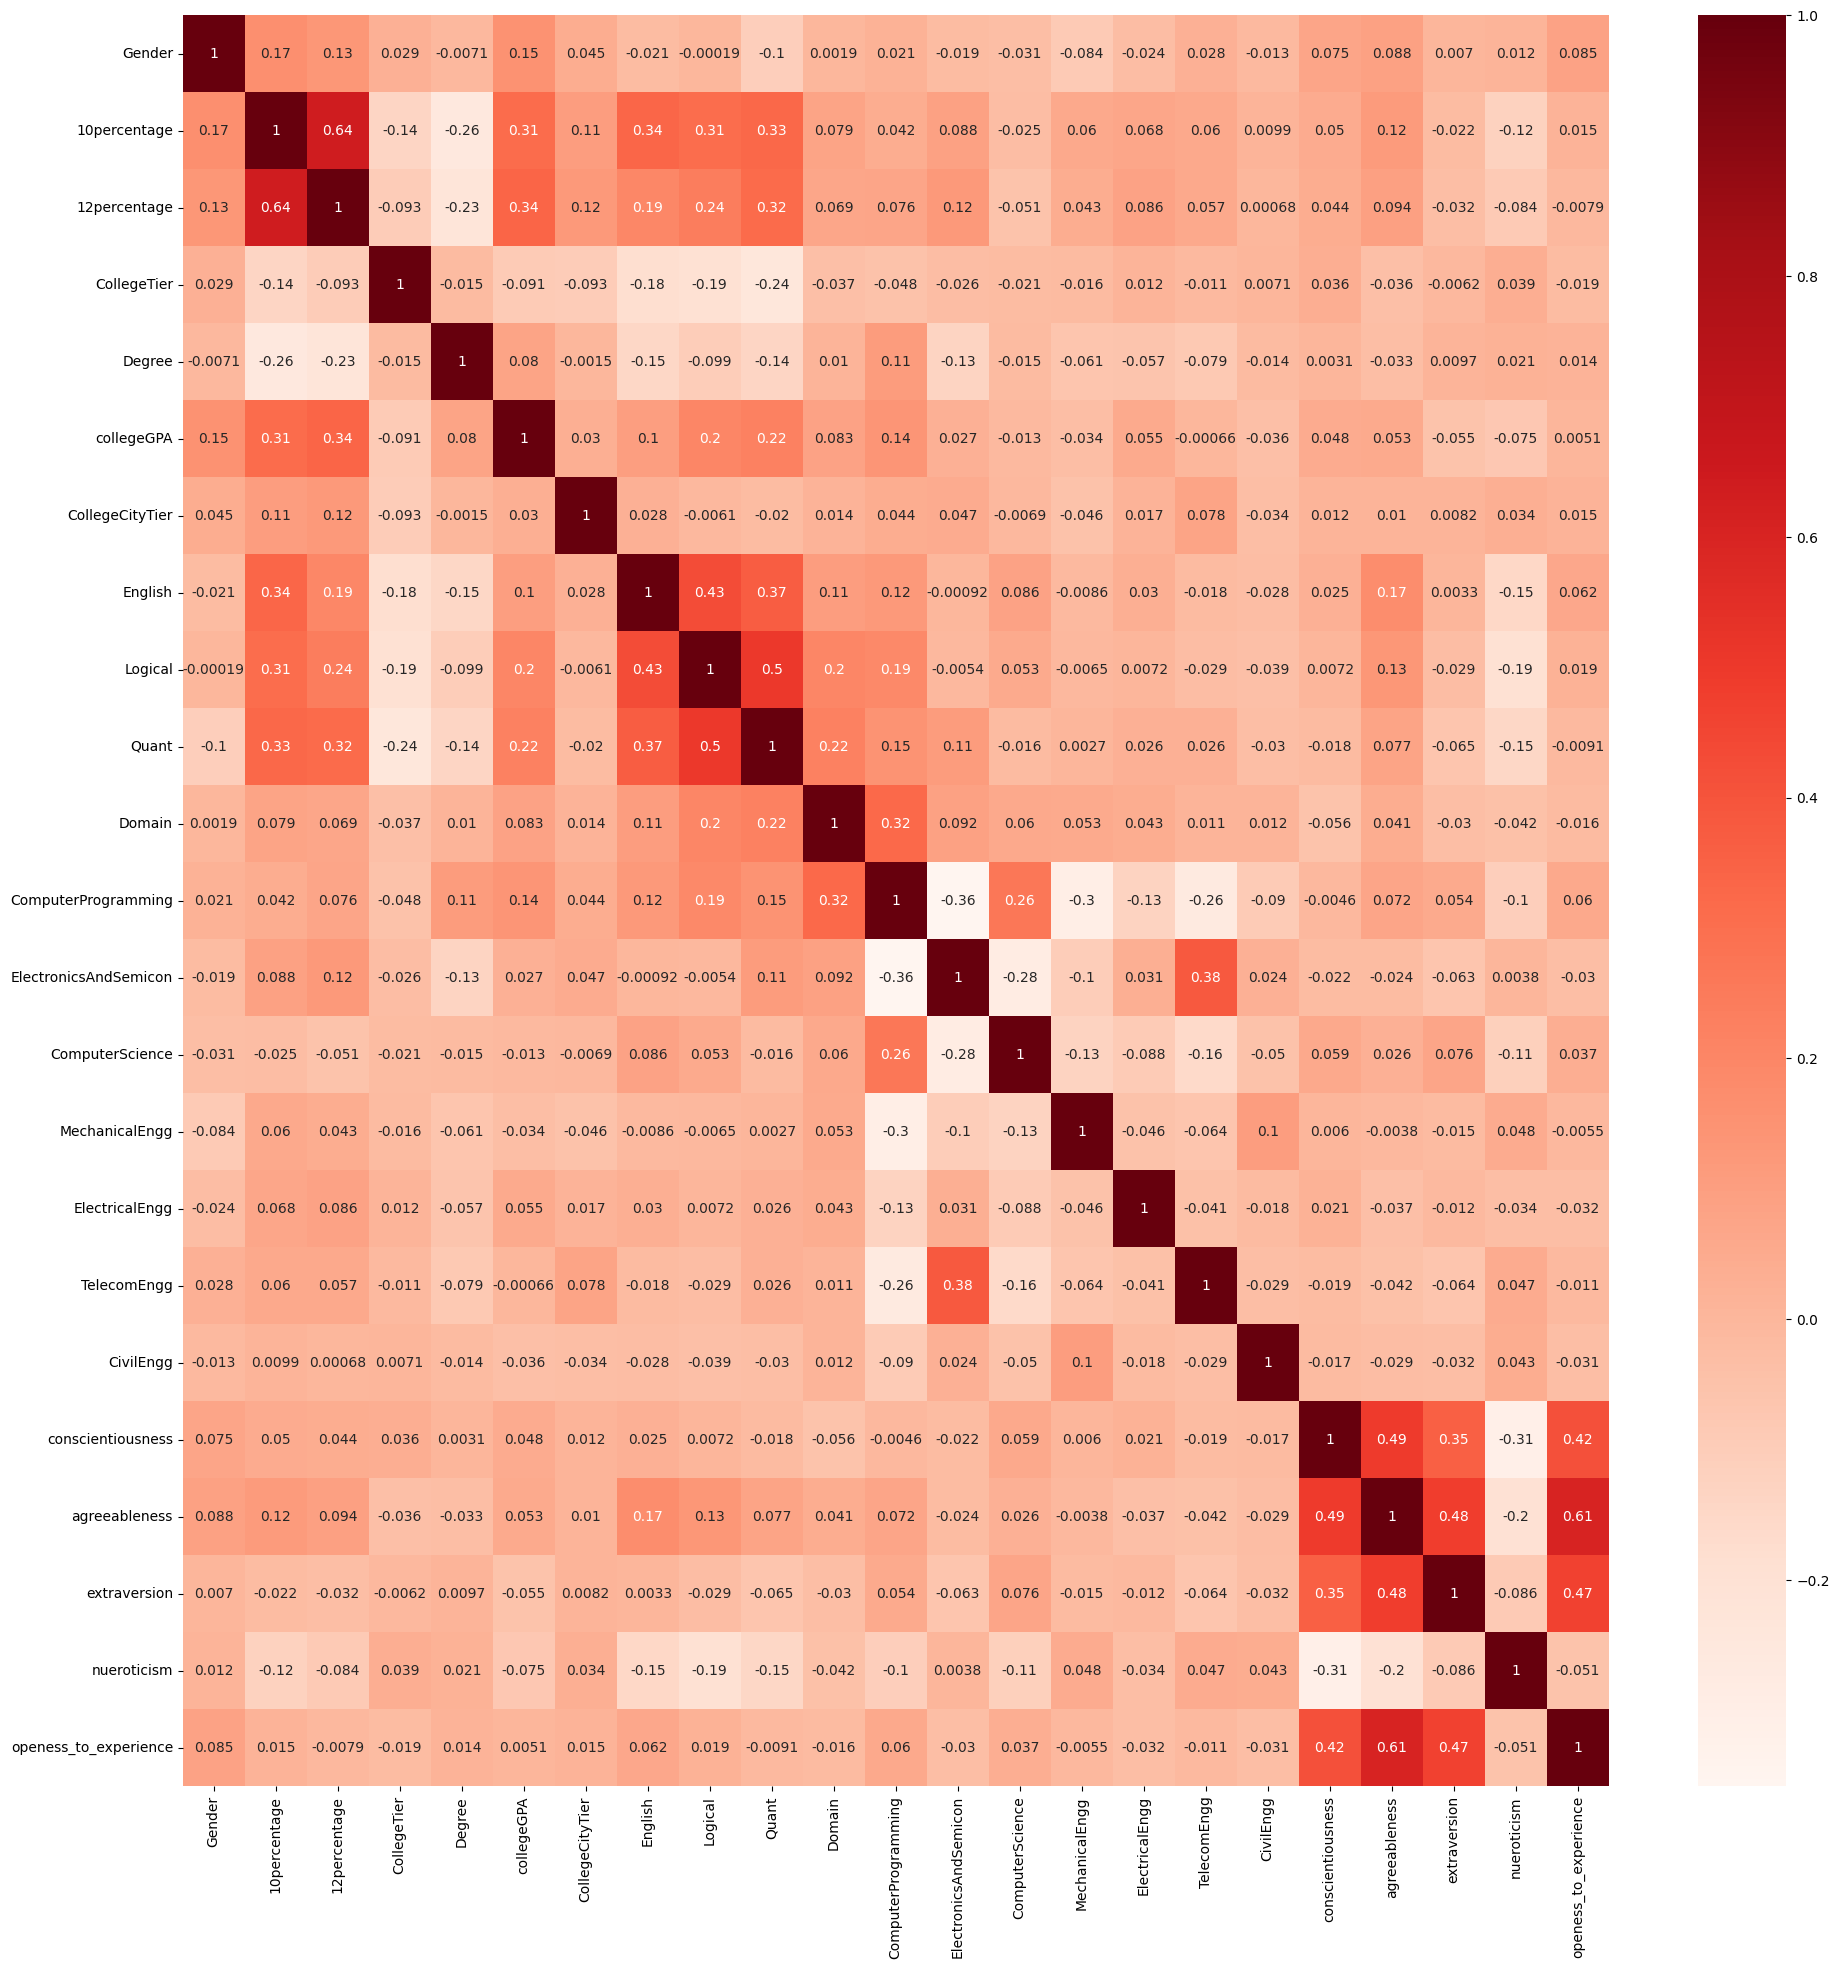

In [1392]:
X_train = train.drop(['Salary'], axis=1)
Y_train = train['Salary']

X_test = test.drop(['Salary'], axis=1)
Y_test = test['Salary']
correlation_matrix = X_train.corr()

plt.figure(figsize=(23, 23))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [1393]:
Features = train.drop(['Salary'], axis=1)
Target = train['Salary']


corr_feature= correlation(Features, 0.5)

X_train = train.drop(corr_feature, axis=1)
model2 = X_train.columns

X_test =  test.drop(corr_feature, axis=1)

Df_np = X_train.to_numpy()
np.random.default_rng().shuffle(Df_np, axis=0)
result2 = cross_validation_model(Df_np, 10)



In [1394]:
print('mae avg of model2: ',result2)

mae avg of model2:  111693.1297607491


In [1395]:
X_train = X_train.drop(['Salary'], axis=1).to_numpy()
y_train = train.loc[:, 'Salary'].to_numpy()

X_test = X_test.drop(['Salary'], axis=1).to_numpy()
y_test = test.loc[:, 'Salary'].to_numpy()

lr = OLSLinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('model2: ', len(model2))
print('mae of model2: ', mae(y_test, y_pred))


model2:  21
mae of model2:  103817.9538696267


### model3 (mutuation information)

In [1396]:
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)



In [1397]:

np.random.seed(0)

selected_top_columns = SelectPercentile(mutual_info_regression, percentile=70)
selected_top_columns.fit(X_train, y_train)



SelectPercentile(percentile=70,
                 score_func=<function mutual_info_regression at 0x7f1cd8f05750>)

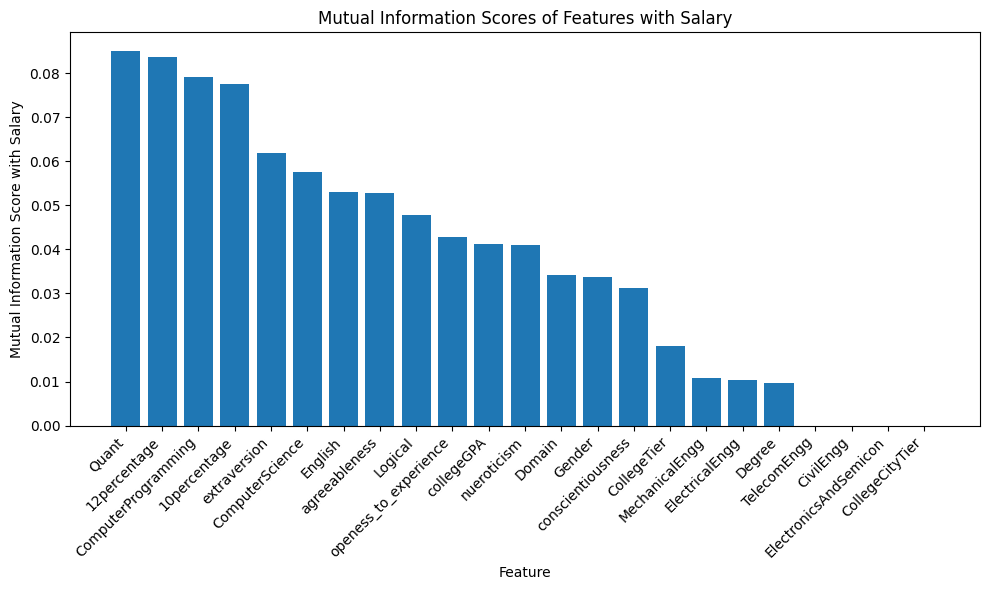

In [1398]:
# Get the mutual information scores
feature_scores = selected_top_columns.scores_

# Get the feature names
feature_names = X_train.columns

# Sort features and scores in descending order
sorted_indices = np.argsort(feature_scores)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_scores = [feature_scores[i] for i in sorted_indices]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(feature_names)), sorted_scores)
plt.xticks(np.arange(len(feature_names)), sorted_feature_names, rotation=45, ha='right')
plt.ylabel('Mutual Information Score with Salary')
plt.xlabel('Feature')
plt.title('Mutual Information Scores of Features with Salary')
plt.tight_layout()

# Show the plot
plt.show()


In [1399]:
select_feature = list(X_train.columns[selected_top_columns.get_support()].values)
select_feature.append("Salary")

X_train = train.loc[:, select_feature]
X_test = test.loc[:, select_feature]

model3 = X_train.columns


Df_np = X_train.to_numpy()
np.random.default_rng().shuffle(Df_np, axis=0)
result3 = cross_validation_model(Df_np, 10)



In [1400]:
print('mae avg of model3: ',result3)

mae avg of model3:  110644.14115900484


In [1401]:
X_train = X_train.drop(['Salary'], axis=1).to_numpy()
y_train = train.loc[:, 'Salary'].to_numpy()

X_test = X_test.drop(['Salary'], axis=1).to_numpy()
y_test = test.loc[:, 'Salary'].to_numpy()

print('X_train: ', X_train.shape)
lr = OLSLinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('model3: ', model3)
print('mae of model3: ', mae(y_test, y_pred))


X_train:  (2248, 16)
model3:  Index(['Gender', '10percentage', '12percentage', 'CollegeTier', 'collegeGPA',
       'English', 'Logical', 'Quant', 'Domain', 'ComputerProgramming',
       'ComputerScience', 'conscientiousness', 'agreeableness', 'extraversion',
       'nueroticism', 'openess_to_experience', 'Salary'],
      dtype='object')
mae of model3:  102431.57002986001


In [1402]:
all_mae_avg = [result1, result2, result3]
model = ['model1', 'model2', 'model3']

print(all_mae_avg)
print('best model is: ',model[np.argmin(all_mae_avg)])

[111939.01181435336, 111693.1297607491, 110644.14115900484]
best model is:  model3
